In [53]:
import networkx as nx
import numpy as np

def get_graph(n_partitions, cluster_sizes):
    return nx.stochastic_block_model(
        sizes=cluster_sizes,
        p=[[np.clip(np.random.normal(0.2, 0.0), 0.0, 1.0) for _ in range(i)] + \
            [np.clip(np.random.normal(0.5, 0.0), 0.0, 1.0)] + \
            [np.clip(np.random.normal(0.2, 0.0), 0.0, 1.0) for _ in range(n_partitions-i-1)]
            for i in range(n_partitions)],
        #directed=True,
    )

In [54]:
import multiprocessing as mp

N_SIMULATIONS = 100

def simulate(i):
    np.random.seed()
    np.random.seed()
    np.random.seed()
    n_partitions = max(int(np.random.normal(10, 10.0)), 1)
    cluster_sizes = [max(int(np.random.normal(100, 10.0)), 1) for _ in range(n_partitions)]
    graph = get_graph(n_partitions=n_partitions, cluster_sizes=cluster_sizes)
    partitions = nx.community.louvain_communities(graph)
    return {"n_partitions": n_partitions, "cluster_sizes": cluster_sizes, "partitions": partitions, "graph": graph}

with mp.Pool() as pool:
    results = pool.map(simulate, range(N_SIMULATIONS))

for result in results:
    print(f"n_partitions: {result['n_partitions']}")
    print(f"cluster_sizes: {result['cluster_sizes']}")
    print(f"partitions found: {len(result['partitions'])}")
    print(f"partitions: {result['partitions']}")
    

n_partitions: 24
cluster_sizes: [97, 96, 100, 93, 105, 118, 96, 99, 98, 97, 101, 103, 84, 91, 116, 104, 96, 98, 115, 95, 110, 99, 105, 108]
partitions found: 10
partitions: [{1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 189, 2383, 1423}, {1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 10

In [55]:
import tqdm

def compute_score(result):
    original_nodes = [i for i in range(sum(result["cluster_sizes"]))]
    original_communities = [[] for _ in range(len(result["cluster_sizes"]))]
    last_index = 0
    for i, cluster_size in enumerate(result["cluster_sizes"]):
        original_communities[i] = original_nodes[last_index:last_index+cluster_size]
        last_index += cluster_size
    
    # Iterate over each pair of vertices (i, j)
    pairs = [(i, j) for i in range(len(original_nodes)) for j in range(i+1, len(original_nodes))]
    correctly_classified_pairs = 0
    for pair in pairs:
        in_same_original_community = False
        for community in original_communities:
            if pair[0] in community and pair[1] in community:
                in_same_original_community = True
                break
        
        in_same_predicted_community = False
        for community in result["partitions"]:
            if pair[0] in community and pair[1] in community:
                in_same_predicted_community = True
                break
        
        if in_same_original_community == in_same_predicted_community:
            correctly_classified_pairs += 1
    
    result["score"] = correctly_classified_pairs / len(pairs)
    return result

with mp.Pool() as pool:
    scored_results = pool.map(compute_score, tqdm.tqdm(results))

100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


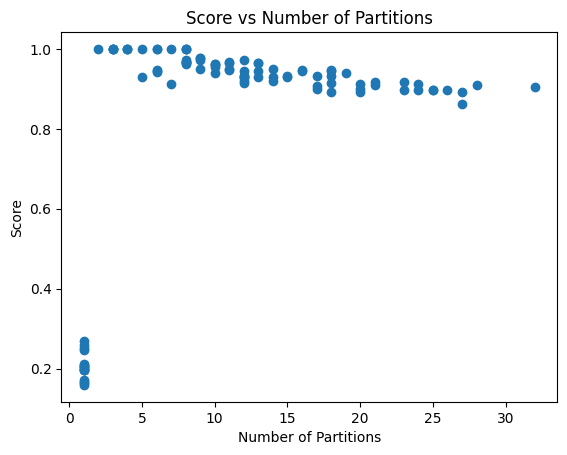

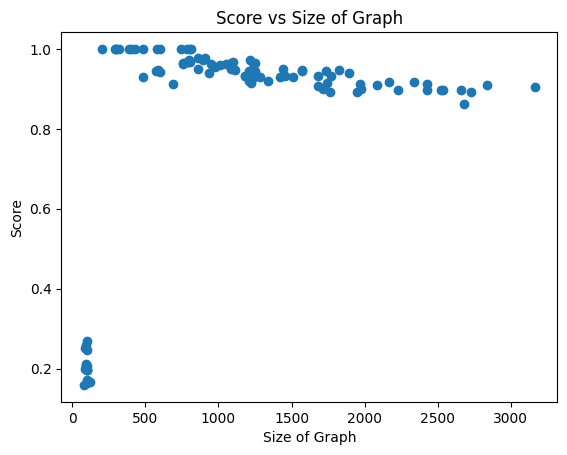

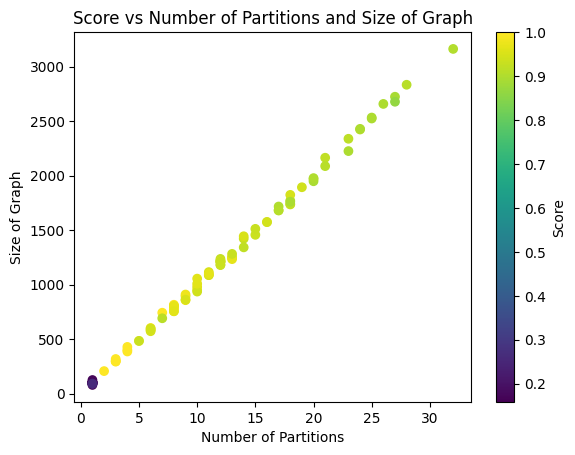

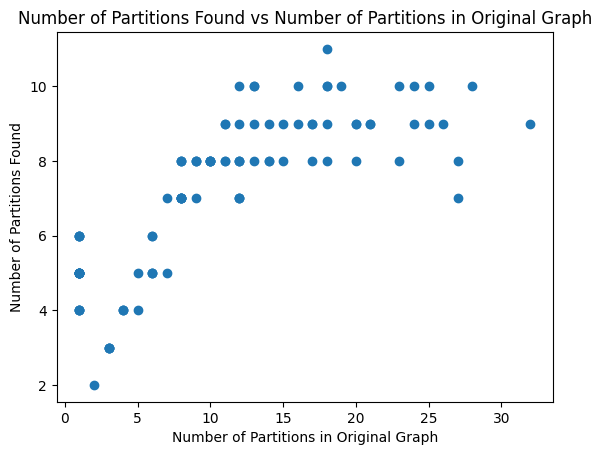

In [60]:
import matplotlib.pyplot as plt

# Plot the score in function of the number of partitions
plt.scatter([result["n_partitions"] for result in scored_results], [result["score"] for result in scored_results])
plt.title("Score vs Number of Partitions")
plt.xlabel("Number of Partitions")
plt.ylabel("Score")
plt.show()

# Plot the score in function of the size of the graph
plt.scatter([sum(result["cluster_sizes"]) for result in scored_results], [result["score"] for result in scored_results])
plt.title("Score vs Size of Graph")
plt.xlabel("Size of Graph")
plt.ylabel("Score")
plt.show()

# Plot the score in function of both the number of partitions and the size of the graph
plt.scatter([result["n_partitions"] for result in scored_results], [sum(result["cluster_sizes"]) for result in scored_results], c=[result["score"] for result in scored_results])
plt.title("Score vs Number of Partitions and Size of Graph")
plt.xlabel("Number of Partitions")
plt.ylabel("Size of Graph")
plt.colorbar(label="Score")
plt.show()

# Plot the number of partitions found in function of the number of partitions in the original graph
plt.scatter([result["n_partitions"] for result in scored_results], [len(result["partitions"]) for result in scored_results])
plt.title("Number of Partitions Found vs Number of Partitions in Original Graph")
plt.xlabel("Number of Partitions in Original Graph")
plt.ylabel("Number of Partitions Found")
plt.show()